# TUTORIAL: TIME METRICS and OOPS METRICS
Author: Jason Helgren

This notebook explains the features generated by the functions timeMetrics and oopsMetrics in metrics.py.

## PART 1: Spectrogram Review

Spectrograms quantify the frequency content of a signal over time. The Matplotlib.mlab function specgram(x) computes a spectrogram for an array, x, and returns a three element tuple (spectrum, freqs, t):
- spectrum: a 2-D array. The columns are successive periodograms. Each periodogram contains the power spectral density, which is a measure of the frequency content of the signal.
- freqs: 1-D array. The frequencies corresponding to the rows in spectrum
- t: 1-D array. The times corresponding to midpoints of segments (i.e the columns in spectrum).

Spectrograms are typically plotted as heat maps, with time on the x axis and frequency on the y axis. The temperature shows the frequency content.

## PART 2: Time Metrics

The time metrics produce aggregate statistics over the rows of the specgram array, i.e. for a given frequency they aggregate over the duration of the signal. The winning submission calculates four statistics for each frequency bin, excluding high frequencies beyond the range of right whale calls, which are typically 100-200 Hz.

To study the time metrics, first read a sample audio file and generate a spectrogram.

In [1]:
# Set path to directory with folders train and test
path_data = '/Users/jason/code/msan630/project/whale/data/'

In [2]:
%matplotlib inline

import aifc
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import mlab, cm
from scipy.stats import skew
import numpy as np
#import pandas as pd
%matplotlib inline

In [3]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

# Read one file as an example
params = {'NFFT':256, 'Fs':2000, 'noverlap':192} 
s = ReadAIFF(path_data + 'train/train6.aiff')
P, freqs, bins = mlab.specgram(s, **params)

In [4]:
P.shape

(129, 59)

The two dimensional array returned by mlab.specgram has 129 frequency bins and 59 time bins.

In [5]:
# Spectrogram plotting function
def plot_spectrogram(ax, P):
    plt.imshow(P, origin='lower', extent=[-6,6,-1,1], aspect=4, cmap = cm.get_cmap('bwr'))
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.set_xticklabels(np.arange(-0.5,2.5,0.5))
    ax.set_yticklabels(range(0,1001,250))
    ax.set_xlabel('Time (seconds)', fontsize = 12)
    ax.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)

The example spectrogram shows a whale call that begins about 500 ms into the recording, lasts approximately 750 ms, and sweeps from about 150 Hz to 250 Hz. Subsequent images compare horizontal (frequency) slices of this spectrogram.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


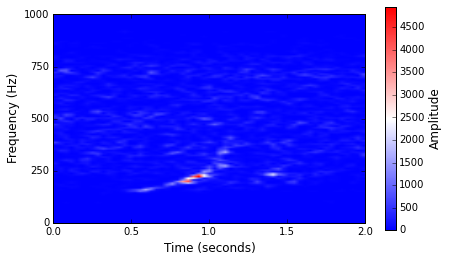

In [6]:
fig = plt.figure(figsize = (7,4))
ax1 = plt.subplot(111)
plot_spectrogram(ax1, P)
plt.show()


To further study this time metric, we'll examine two frequency bins: one at approximately 200 Hz that includes the whale call, and at a lower frequency without the whale call.

Choose two indecies, f1 and f2:

In [7]:
# Indecies 25 and 5 correspond to frequencies of about 200 Hz and 40 Hz, respectively.
f1, f2 = 25, 5
freqs[f1], freqs[f2]

(195.3125, 39.0625)

In [8]:
# Reassign time bins returned by specgram (convenience so variables match winning submission)
b = bins
# Limit statistics to about 470 Hz.
maxM = 60 
freqs[maxM]

468.75

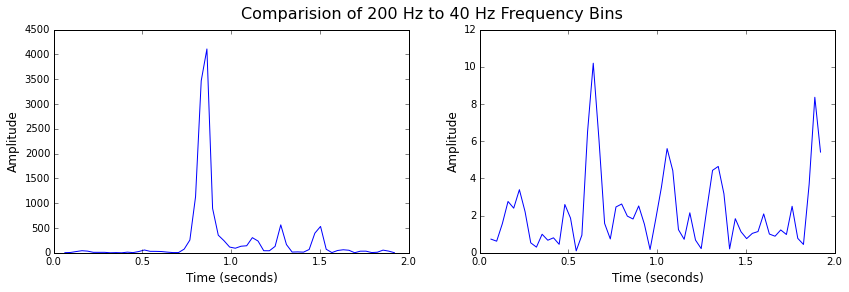

In [9]:
fig = plt.figure(figsize = (14,4))
ax1 = plt.subplot(121)
ax1.plot(b, P[f1,:])
ax1.set_xlabel('Time (seconds)', fontsize = 12)
ax1.set_ylabel('Amplitude', fontsize = 12)
ax2 = plt.subplot(122)
ax2.plot(b, P[f2,:])
ax2.set_xlabel('Time (seconds)', fontsize = 12)
ax2.set_ylabel('Amplitude', fontsize = 12)
plt.suptitle('Comparision of 200 Hz to 40 Hz Frequency Bins', fontsize = 16)
plt.show()

### First time metric: centroid
Code from the winning submission:
    
    # centroid = sum(x*t)/sum(x)
    cf_ = [np.sum(P[i,:]*b)/np.sum(P[i,:]) for i in range(maxM)]
    
cf\_ is an array of the centroids for each frequency bin, limited by maxM. The winning submission uses maxM = 60, which limits the frequency bins to approximately 460 Hz. Each element in cf\_ is the center of mass, in seconds, of the signal. Note that * performs elementwise multiplication in Numpy.

In [10]:
cf_ = [np.sum(P[i,:]*b)/np.sum(P[i,:]) for i in range(maxM)]

In [11]:
centroid = lambda i: np.sum(P[i,:]*b)/np.sum(P[i,:])

In [12]:
centroid(f1), centroid(f2)

(0.95449894998224083, 1.0371017604944963)

As expected, the centroid of the higher frequency signal at 0.95 s corresponds roughly to the peak. The lower frequency signal is mostly noise (note the difference in axis range) and thus the centroid corresponds to the midpoint of the recording.

### Second time metric: width


Code from the winning submission:

    # width = sqrt(sum(x*(t-centroid)^2)/sum(x))
    bw_ = [np.sum(P[i,:]*(b - cf_[i])*(b - cf_[i]))/np.sum(P[i,:]) for i in range(maxM)]

bw\_ is an array of the widths for each frequency bin, again limited by maxM. Frequency bins with a prominent peak return a low width value.

In [13]:
width = lambda i: np.sum(P[i,:]*(b - cf_[i])*(b - cf_[i]))/np.sum(P[i,:])

In [14]:
width(f1), width(f2)

(0.062066806301463398, 0.28842006115145313)

### Third time metric: skew

Code from the winning submission:

    # skew = scipy.stats.skew
    sk_ = [skew(P[i,:]) for i in range(maxM)]
    
sk\_ contains a list of skew values, calculated with scipy.stats.skew, for each frequency bin. Distributions with heavy tails have a nonzero skew.

In [15]:
skew(P[f1,:]), skew(P[f2,:])

(4.563726256576307, 1.8173726701802764)

### Fourth time metric: total variation

Code from the winning submission:
    
    # total variation = sum(abs(x_i+1 - x_i))
    tv_ = [np.sum(np.abs(P[i,1:] - P[i,:-1])) for i in range(maxM)]
    
tv\_ contains a list of total variations for each frequency bin. A constant or low amplitude noise signal will have little variation, whereas a signal with a strong peak or high amplitude noise will have high variation.

In [16]:
total_variation = lambda i: np.sum(np.abs(P[i,1:] - P[i,:-1]))

In [17]:
total_variation(f1), total_variation(f2)

(11217.249069321666, 80.828991280665278)

## PART 3: Oops Metrics

The author of the winning submission indicates that the "oopsMetrics" were supposed to identical to the time metrics, but aggregated over time bins instead of frequency bins. Thus, the centroid code was supposed to be:
    
    cf_ = [np.sum(P[:,i]*b)/np.sum(P[:,i]) for i in range(maxM)]
    
The author made an error and instead defined the centroid to be (note the differene in array slicing):

    cf_ = [np.sum(P[i,:]*b)/np.sum(P[:,i]) for i in range(maxM)]
    
This erroneous calculation apparently had discriminatory power, thus he retained the incorrect code.

In [18]:
oops_centroid = lambda i: np.sum(P[i,:]*b)/np.sum(P[:,i])

In [19]:
oops_centroid(f1), oops_centroid(f2)

(0.64225876409262472, 0.023911798174883127)